In [1]:
import utils
from lyft_simulation import *

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import json

#### handle virtual environment
#### conda create -n ride_sim python=3.9
#### conda activate ride_sim
#### conda install ipykernel 
#### python -m ipykernel install --user --name=ride_sim

In [3]:
city_locations = [(0.1, 0.1, 0.2, 5.0), (0.5, 0.9, 0.2, 5.0)]

In [4]:
airport_locations = [(0.9, 0.1, 0.05, 10.0)]

In [5]:
probability_density = utils.create_probability_density(city_locations, airport_locations)

#### generate a random of 1000 locations based on the prob density

In [6]:
num_locations = 1000
locations = [utils.generate_random_location(probability_density) for _ in range(num_locations)]

In [18]:
[(x, y) for x, y in locations if x<0 or y<0 ]

[]

In [14]:
locations_df = pd.DataFrame(locations, columns=['x', 'y'])

<Axes: xlabel='x', ylabel='y'>

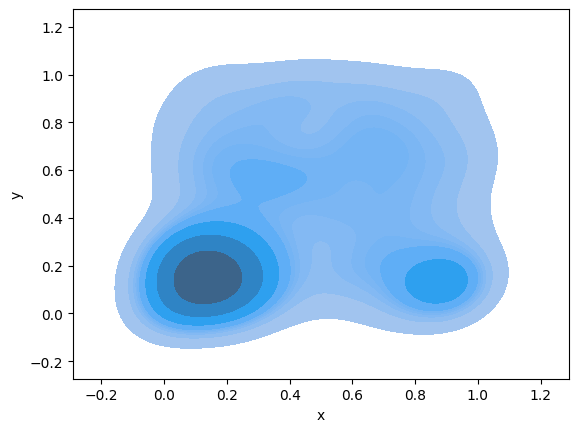

In [20]:
#the KDE can produce values that are below 0 even if all the input data values are positive
#estimating the probability density function of the data by smoothing the points with a Gaussian kernel
sns.kdeplot(
    #, hue="kind" for driver or rider
    data=locations_df, x="x", y="y", fill=True
)

#### initialize driver and riders

In [6]:
T0_pricing_params = (5, 0.78, 1.82)
lr = 0.01
simulation_round1 = LyftSimulation(lr, T0_pricing_params)

In [7]:
simulation_round1.initialize_drivers()

In [8]:
simulation_round1.initialize_riders()

In [9]:
simulation_round1.add_requests()

100%|██████████| 1000/1000 [00:00<00:00, 34540.07it/s]


In [10]:
init_driver_dict, init_rider_dict = simulation_round1.drivers, simulation_round1.riders

In [11]:
len(init_driver_dict), len(init_rider_dict)

(100, 1000)

In [15]:
init_rider_dict['1048ccc7-b291-488d-8b48-567b97fc31b4']

{'type': 'commuter',
 'requests': [],
 'num_rejects_by_rider': 0,
 'home_address': (0.49916366103509746, 0.7993027373591876),
 'work_address': (0.12218804112609027, 0.14670625021689265)}

In [13]:
utils.save_dict_to_json(init_driver_dict, 'data/init_drivers.json')

In [14]:
utils.save_dict_to_json(init_rider_dict, 'data/init_riders.json')

#### tuples will be serialized to list when saving to a json file

In [15]:
# with open('data/events.json', 'w') as fp:
#     json.dump(simulation_round1.events, fp, cls=EventEncoder)

In [15]:
event_dicts = [event.to_dict() for event in simulation_round1.events]

In [16]:
event_dicts = sorted(event_dicts, key=lambda x: x['timestamp'])

In [28]:
len(event_dicts)

3145

In [27]:
with open('data/events.json', 'w') as fp:
    json.dump(event_dicts, fp)

In [18]:
loaded_init_driver_dict = utils.read_json('data/init_drivers.json')

In [19]:
drivers_lst = [v['cur_loc'] for k, v in loaded_init_driver_dict.items()]

In [20]:
init_locations_drivers_df = pd.DataFrame(drivers_lst, columns=['x', 'y'])

In [21]:
init_locations_drivers_df['type'] = 'driver'

In [22]:
loaded_init_rider_dict = utils.read_json('data/init_riders.json')
riders_lst = [v['home_address'] for k, v in loaded_init_rider_dict.items()]
init_locations_riders_df = pd.DataFrame(riders_lst, columns=['x', 'y'])
init_locations_riders_df['type'] = 'rider'

In [23]:
init_locations_df = pd.concat([init_locations_drivers_df, init_locations_riders_df]).reset_index().iloc[:, 1:]

In [24]:
init_locations_df.shape

(1100, 3)

<Axes: xlabel='x', ylabel='y'>

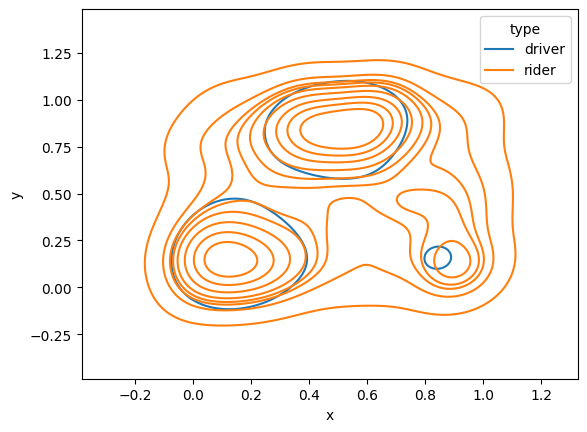

In [25]:
sns.kdeplot(
    #hue="type" for driver or rider
    data=init_locations_df, x="x", y="y", fill=False, hue='type'
)

In [ ]:
#### TODO - do kde plot on rider's request locations every day categorized by start and end locations